In [1]:
import os
os.chdir('C:\\Users\\Administrator\\Downloads\\ML Lab')

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input, SimpleRNN
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [5]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [6]:
def create_rnn():
    input_data = Input(shape=(time_steps, num_features))
    rnn_layer1 = SimpleRNN(8, return_sequences=True)(input_data)
    rnn_layer2 = SimpleRNN(20)(rnn_layer1)
    x = Flatten()(rnn_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [7]:
model1 = create_rnn()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 24, 8)             240       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                580       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


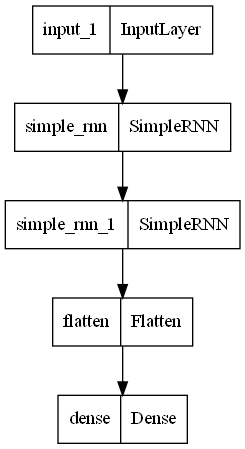

In [8]:
tensorflow.keras.utils.plot_model(model1 )

In [9]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [10]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [13]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_rnn()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [14]:
import os
path_dataset ='C:\\Users\\Administrator\\Downloads\\ML Lab\\AEP_hourly\\processed'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

C:\Users\Administrator\anaconda3\envs\Time1\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [15]:
time_steps=24
num_features=21

In [16]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.3590257167816162 sec


In [17]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2649/2653 [============================>.] - ETA: 0s - loss: 0.0437 - mae: 0.0437 - mape: 274.4622
Epoch 1: val_loss improved from inf to 0.01374, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E1-cp-0001-loss0.01.h5
2653/2653 [==============================] - 30s 11ms/step - loss: 0.0437 - mae: 0.0437 - mape: 274.1000 - val_loss: 0.0137 - val_mae: 0.0137 - val_mape: 6.8614
Epoch 2/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0138 - mae: 0.0138 - mape: 297.6231
Epoch 2: val_loss improved from 0.01374 to 0.01058, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E1-cp-0002-loss0.01.h5
2653/2653 [==============================] - 30s 11ms/step - loss: 0.0138 - mae: 0.0138 - mape: 297.5607 - val_loss: 0.0106 - val_mae: 0.0106 - val_mape: 4.6947
Epoch 3/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0119 - mae: 0.0119 - mape: 58.4868
Epoch 3: val_loss did not improve from 0.0105

In [20]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E1-cp-0053-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 2s 4ms/step
Mean Absolute Error (MAE): 110.66
Median Absolute Error (MedAE): 88.57
Mean Squared Error (MSE): 21191.35
Root Mean Squared Error (RMSE): 145.57
Mean Absolute Percentage Error (MAPE): 0.76 %
Median Absolute Percentage Error (MDAPE): 0.61 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [21]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E1-cp-0053-loss0.01.h5'
start_epoch= 54

In [22]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E1-cp-0053-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [ ]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2648/2653 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 8.6717
Epoch 1: val_loss improved from inf to 0.00682, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 31s 11ms/step - loss: 0.0064 - mae: 0.0064 - mape: 8.6602 - val_loss: 0.0068 - val_mae: 0.0068 - val_mape: 3.0920
Epoch 2/10
2651/2653 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 2.4142
Epoch 2: val_loss improved from 0.00682 to 0.00649, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 34s 13ms/step - loss: 0.0064 - mae: 0.0064 - mape: 2.4140 - val_loss: 0.0065 - val_mae: 0.0065 - val_mape: 2.8914
Epoch 3/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 8.4092
Epoch 3: val_loss did not improve from 0.00649
2653/26

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-0006-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 144.75
Median Absolute Error (MedAE): 113.65
Mean Squared Error (MSE): 36189.68
Root Mean Squared Error (RMSE): 190.24
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.79 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
